In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Some references
https://machinelearningmastery.com/xgboost-python-mini-course/  
https://www.kaggle.com/eikedehling/tune-and-compare-xgb-lightgbm-rf-with-hyperopt

# Dataset loading

In [2]:
dataset = pd.read_csv('../Y3 - Sample data/Z2 - datasetprepclean.csv', index_col = 0,
                     )
print('dataset shape:', dataset.shape)
dataset.head()

dataset shape: (5401, 665)


,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,minimum_rectangle_dim2,convex_hull_area,no_hole_area,thickness,...,bendlength_bend_edge_length_min_04,bendlength_bend_edge_length_max_04,weight,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group
COART,,,,,,,,,,,,,,,,,,,,,
L1600360,3178.489502,9,0,285678.093750,431798.46875,722.070984,598.000000,320484.593750,286893.718750,4.0,...,29.010676,594.972659,13.273485,12.51,5.15,17.66,0.000010,0.000007,0.000011,3-5
L1600470,317.114502,1,0,3403.138184,3500.00000,140.000000,25.000000,3403.138184,3403.138184,10.0,...,0.000000,0.000000,0.268975,0.25,0.92,1.17,0.000007,0.000007,0.000007,0
L1600600,3710.627930,1,0,522587.812500,522587.81250,1509.000000,346.313995,522587.812500,522587.812500,3.0,...,0.000000,0.000000,12.048263,18.36,7.55,25.91,0.000012,0.000012,0.000012,1-2
L1600610,3232.627930,1,0,439818.781250,439818.78125,1270.000000,346.313995,439818.781250,439818.781250,3.0,...,0.000000,0.000000,10.140022,9.18,4.77,13.95,0.000007,0.000007,0.000007,1-2
L1600620,2972.627930,1,0,394797.968750,394797.96875,1140.000000,346.313995,394797.968750,394797.968750,3.0,...,0.000000,0.000000,9.102067,9.18,4.65,13.83,0.000008,0.000008,0.000008,1-2


In [3]:
#dataset.columns.values

In [4]:
for index, nancount in dataset.isnull().sum().iteritems():
    if nancount != 0:
        print(index, '-->', nancount)
else:
    print('Done !')

dataset.shape

benddxf_deformation_length_00 --> 262
benddxf_deformation_length_01 --> 123
benddxf_deformation_length_02 --> 19
benddxf_deformation_length_03 --> 6
benddxf_deformation_length_04 --> 1
benddxf_deformation_length_05 --> 1
bendlength_deformation_length_00 --> 296
bendlength_deformation_length_01 --> 112
bendlength_deformation_length_02 --> 3
bendlength_deformation_length_03 --> 1
Done !


(5401, 665)

In [5]:
#Cleaning of the remaining Nan

subset = [x for x in dataset.columns.values if x.startswith('benddxf_')]
subset  = [x for x in dataset.columns.values if x.startswith('bendlength_')]


#dataset = dataset.fillna(0)
dataset = dataset.dropna(subset=subset)
dataset.shape

(5105, 665)

# cleaning to have at least min occurences

In [6]:
minocc = 50
todrop = []
df = dataset['thickness'].reset_index().groupby('thickness').count()
for index, occ in df.iterrows():
    if occ.COART <= minocc:
        print(occ.COART)
        todrop.append(index)
        print(index, 'will be dropped')

for thickness in todrop:
    dataset = dataset[dataset['thickness'] != thickness]

dataset.shape

33
1.5 will be dropped
1
2.5 will be dropped
6
20.0 will be dropped


(5065, 665)

# Target definition

In [7]:
target = 'VALAJOUT'
assert target in ['VAMAT', 'VALAJOUT', 'VALTOT'], 'The target must be in y dataset'

# Is the target "normal" ?

In [8]:
from scipy.stats import skew
skew(dataset[target]) #Nope !

3.1520528420901357

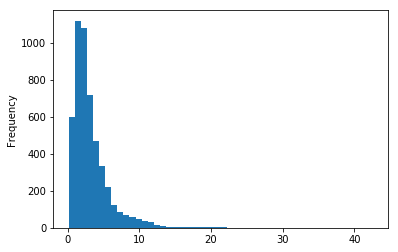

In [9]:
dataset[target].plot.hist(bins=50)
plt.show()

# Outlier tracking - VAMAT

In [10]:
toplimit = .95 #We drop the top 5%
botlimit = .02 #we drop the bottom 2%

In [11]:
#Surface cost calculation, quantile decomposition

#dataset['SURF_COST_CONVHULL'] = dataset['VAMAT'] / dataset['convex_hull_area']
#dataset['SURF_COST_RECTANGLE'] = dataset['VAMAT'] / dataset['minimum_rectangle_area']
dataset['SURF_COST_MPATTERN'] = dataset['VAMAT'] / dataset['no_hole_area']
#dataset['SURF_COST_TOTAREA'] = dataset['VAMAT'] / dataset['total_area']

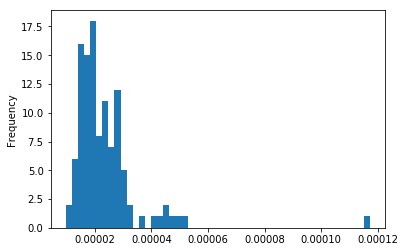

In [12]:
df = dataset[dataset['thickness'] == 2]
df['SURF_COST_MPATTERN'].plot.hist(bins=50)
plt.show()

In [13]:
#quantile decomposition
df=dataset[['thickness', 'SURF_COST_MPATTERN']].groupby('thickness').quantile([botlimit,toplimit])
df

SURF_COST_MPATTERN
thickness                         
2.0       0.02            0.000013
          0.95            0.000045
3.0       0.02            0.000018
          0.95            0.000060
4.0       0.02            0.000023
          0.95            0.000089
5.0       0.02            0.000028
          0.95            0.000091
6.0       0.02            0.000033
          0.95            0.000134
8.0       0.02            0.000044
          0.95            0.000182
10.0      0.02            0.000063
          0.95            0.000248
12.0      0.02            0.000059
          0.95            0.000247
15.0      0.02            0.000085
          0.95            0.000271

In [14]:
# If vamat is target, cleaning
if target == 'VAMAT' or target == 'VALTOT':
    for (thickness, limit), value in df.iterrows():
        tresh = value.values[0]
        if limit == botlimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(5065, 666)

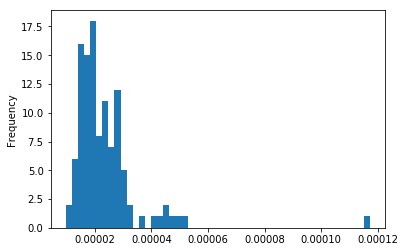

In [15]:
df = dataset[dataset['thickness'] == 2]
df['SURF_COST_MPATTERN'].plot.hist(bins=50)
plt.show()

In [16]:
skew(dataset[target])

3.1520528420901357

# Outlier tracking - VALAJOUT

In [17]:
toplimit = .95 #We drop the top 5%
botlimit = .02 #we drop the bottom 2%

In [18]:
#Cost per bend calculation

dataset['APPROX_BEND_COST'] = dataset['VALAJOUT'] / (dataset['bend_count']+1)

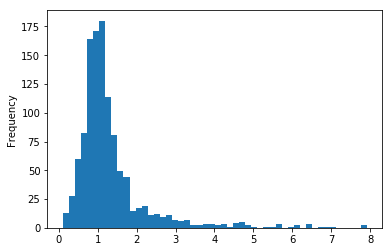

In [19]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

In [20]:
#quantile decomposition
df=dataset[['thickness', 'APPROX_BEND_COST', 'bend_count']].groupby(['thickness', 'bend_count']).quantile([botlimit,toplimit])
df

APPROX_BEND_COST
thickness bend_count                       
2.0       0          0.02          0.707200
                     0.95          7.668000
          1          0.02          0.523400
                     0.95          2.293750
          2          0.02          0.246800
                     0.95          2.151000
          3          0.02          0.624700
                     0.95          2.315000
          4          0.02          0.573280
                     0.95          2.137800
          5          0.02          0.224867
                     0.95          2.048667
          6          0.02          0.703314
                     0.95          1.496000
          7          0.02          0.700500
                     0.95          1.551500
          8          0.02          0.782978
                     0.95          2.421111
          9          0.02          0.639000
                     0.95          0.639000
          14         0.02          0.502000
                     0.95          0.502000
          20         0.02          0.759048
                     0.95          0.759048
3.0       0          0.02          0.219200
                     0.95          7.194000
          1          0.02          0.394200
                     0.95          1.532500
          2          0.02          0.405267
                     0.95          1.944833
...                                     ...
10.0      0          0.02          0.607000
                     0.95          8.637500
          1          0.02          0.971300
                     0.95          4.041250
          2          0.02          0.499267
                     0.95          3.350000
          3          0.02          0.990500
                     0.95          3.877500
          4          0.02          1.137600
                     0.95          3.032000
          5          0.02          1.855000
                     0.95          1.855000
12.0      0          0.02          0.565800
                     0.95          6.811000
          1          0.02          0.165000
                     0.95          2.292500
          2          0.02          0.716667
                     0.95          1.755333
          3          0.02          0.615000
                     0.95          1.041000
          4          0.02          0.848240
                     0.95          1.819400
15.0      0          0.02          0.691600
                     0.95          8.982000
          1          0.02          1.100000
                     0.95          2.962250
          2          0.02          0.853333
                     0.95          1.725000
          3          0.02          0.870000
                     0.95          1.795000

[150 rows x 1 columns]

In [21]:
# If VALAJOUT is target, cleaning
if target == 'VALAJOUT' or target == 'VALTOT':
    for (thickness, bend_count, limit), value in df.iterrows():
        tresh = value.values[0]
        mask1 = np.logical_and(dataset['thickness'] == thickness, dataset['bend_count'] == bend_count)
        if limit == botlimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(4651, 667)

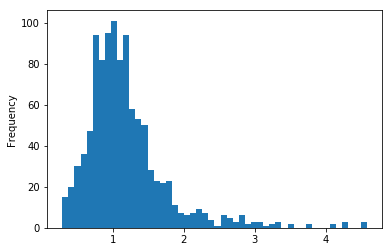

In [22]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

## Target review

In [23]:
#Dataset definition
X = dataset
y = dataset[['VAMAT', 'VALAJOUT', 'VALTOT']]

,VALAJOUT
count,4651.000000
mean,2.864863
std,2.096624
min,0.220000
25%,1.480000
50%,2.370000
75%,3.620000
max,21.790000


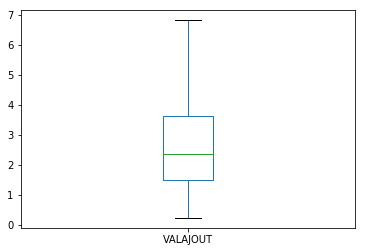

In [24]:
y[[target]].plot.box(sym='')
y[[target]].describe()

# Dataset re-ordering and Splitting

In [25]:
limitedset = ['cut_length', 'num_closed_patterns', 'num_open_patterns', 'total_area', 'minimum_rectangle_area',
              'minimum_rectangle_dim1', 'minimum_rectangle_dim2', 'convex_hull_area', 'no_hole_area', 'weight']

# 1 Bend as a float
limitedset.append('thickness')

# 2 Thickness as categories
#limitedset.extend([x for x in dataset.columns.values if x.startswith('thick_')])

# 3 Different counts
limitedset.extend(['radius_count', 'direction_count', 'bend_count'])

# 4 Bends in groups
#limitedset.extend([x for x in dataset.columns.values if x.startswith('bend_gr_')])

# 5 bends according DXF
#limitedset.extend([x for x in dataset.columns.values if x.startswith('benddxf_')])

# 6 according DXF, sorted by length
#limitedset.extend([x for x in dataset.columns.values if x.startswith('bendlength_')])


print(len(limitedset))
limitedset

14


['cut_length',
 'num_closed_patterns',
 'num_open_patterns',
 'total_area',
 'minimum_rectangle_area',
 'minimum_rectangle_dim1',
 'minimum_rectangle_dim2',
 'convex_hull_area',
 'no_hole_area',
 'weight',
 'thickness',
 'radius_count',
 'direction_count',
 'bend_count']

In [26]:
# Dataset splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0 ,stratify=dataset['bend_group'])

print(X_train.shape, X_test.shape)

#ONLY FOR DATASET CLEANING PURPOSE
#X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.5, random_state=0 ,stratify=dataset['bend_group'])

(3255, 667) (1396, 667)


# Box_cox feature creation

In [27]:
from scipy import stats
from scipy.special import inv_boxcox
_, lmbda = stats.boxcox(y_train[target], lmbda=None)
y_train['logtarget'] = y_train[target].apply(lambda x: stats.boxcox(x, lmbda))
y_test['logtarget'] = y_test[target].apply(lambda x: stats.boxcox(x, lmbda))

/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Blocs creation

In [28]:
#Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [29]:
# Metric MSE
from sklearn.metrics import mean_squared_error

In [30]:
# Metric MAE
from sklearn.metrics import mean_absolute_error

In [31]:
# Metric MAPE Mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import make_scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
mape_scorer

make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [32]:
#regressions
import xgboost as xgb

xgb1 = xgb.XGBRegressor(random_state=0, n_estimators = 300, n_jobs=-2, eval_metric='rmse')

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Direct prediction

## Step 1

In [34]:
#Pipe definition
pipe1 = [('scaler', scaler), ('xgb', xgb1)]

In [35]:
regpip1 = Pipeline(pipe1)

In [36]:
# STEP1

if target == 'VAMAT':
    param_grid = {
        #'xgb__max_depth':range(3,20,2),
        'xgb__max_depth':[3,5,7],
        #'xgb__min_child_weight':range(3,7,2),
        'xgb__min_child_weight':[5,7, 9, 10],
    }
elif target == 'VALAJOUT':
    param_grid = {
        #'xgb__max_depth':range(3,20,2),
        'xgb__max_depth':[3,4,5],
        #'xgb__min_child_weight':range(3,7,2),
        'xgb__min_child_weight':[4,5,6,7],
    }
else:
    param_grid = {
        #'xgb__max_depth':range(3,20,2),
        'xgb__max_depth':[3,4,5],
        #'xgb__min_child_weight':range(3,7,2),
        'xgb__min_child_weight':[4,5,6,7],
    }

In [37]:
%%time
#MSE version
gridxgb1 = GridSearchCV(regpip1, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_squared_error', verbose=2)

#MAPE version
#gridxgb1 = GridSearchCV(regpip1, param_grid, cv=3, n_jobs=-2, scoring=mape_scorer, verbose=1)


gridxgb1.fit(X_train[limitedset], y_train[target])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] xgb__max_depth=3, xgb__min_child_weight=4 .......................
[CV] xgb__max_depth=3, xgb__min_child_weight=4 .......................
[CV] xgb__max_depth=3, xgb__min_child_weight=4 .......................
[CV] ........ xgb__max_depth=3, xgb__min_child_weight=4, total=   1.0s
[CV] xgb__max_depth=3, xgb__min_child_weight=5 .......................
[CV] ........ xgb__max_depth=3, xgb__min_child_weight=4, total=   1.0s
[CV] xgb__max_depth=3, xgb__min_child_weight=5 .......................
[CV] ........ xgb__max_depth=3, xgb__min_child_weight=4, total=   1.0s
[CV] xgb__max_depth=3, xgb__min_child_weight=5 .......................
[CV] ........ xgb__max_depth=3, xgb__min_child_weight=5, total=   0.9s
[CV] ........ xgb__max_depth=3, xgb__min_child_weight=5, total=   1.0s
[CV] xgb__max_depth=3, xgb__min_child_weight=6 .......................
[CV] xgb__max_depth=3, xgb__min_child_weight=6 .......................
[CV] ........ xg

[Parallel(n_jobs=-2)]: Done  36 out of  36 | elapsed:   15.9s finished


CPU times: user 1.95 s, sys: 94.4 ms, total: 2.04 s
Wall time: 16.6 s


In [38]:
print('target        :', target)
print('best score    :', gridxgb1.best_score_)
print('best params   :', gridxgb1.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], gridxgb1.predict(X_test[limitedset]))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], gridxgb1.predict(X_test[limitedset]))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], gridxgb1.predict(X_train[limitedset]))
print('MSE train set :', msetrain)
print()
print('initial params :', xgb1.get_params())

target        : VALAJOUT
best score    : -0.6275555491811226
best params   : {'xgb__max_depth': 4, 'xgb__min_child_weight': 6}
MAPE test set : 20.869346882405555
MSE  test set : 0.6289845187655494
MSE train set : 0.19526694363611696

initial params : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 300, 'n_jobs': -2, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'eval_metric': 'rmse'}


## Step 2

In [39]:
# STEP2

if target == 'VAMAT':
    param_grid = {
        'xgb__gamma':np.linspace(0,1,5)
    }
elif target == 'VALAJOUT':
    param_grid = {
        'xgb__gamma':np.linspace(0,1,5)
    }
else:
    param_grid = {
        'xgb__gamma':np.linspace(0,1,5)
    }
cleaneddict = {k[5:]:v for k,v in gridxgb1.best_params_.items()}
mergeddict = {**xgb1.get_params(), **cleaneddict}
xgb2 = xgb.XGBRegressor(**mergeddict)
pipe2 = [('scaler', scaler), ('xgb', xgb2)]
regpip2 = Pipeline(pipe2)
gridxgb2 = GridSearchCV(regpip2, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_squared_error', verbose=2)

gridxgb2.fit(X_train[limitedset], y_train[target])

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] xgb__gamma=0.0 ..................................................
[CV] xgb__gamma=0.0 ..................................................
[CV] xgb__gamma=0.0 ..................................................
[CV] ................................... xgb__gamma=0.0, total=   1.3s
[CV] xgb__gamma=0.25 .................................................
[CV] ................................... xgb__gamma=0.0, total=   1.4s
[CV] xgb__gamma=0.25 .................................................
[CV] ................................... xgb__gamma=0.0, total=   1.4s
[CV] xgb__gamma=0.25 .................................................
[CV] .................................. xgb__gamma=0.25, total=   1.2s
[CV] xgb__gamma=0.5 ..................................................
[CV] .................................. xgb__gamma=0.25, total=   1.2s
[CV] xgb__gamma=0.5 ..................................................
[CV] ............

[Parallel(n_jobs=-2)]: Done  15 out of  15 | elapsed:    6.5s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=...ate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'xgb__gamma': array([0.  , 0.25, 0.5 , 0.75, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [40]:
print('target        :', target)
print('best score    :', gridxgb2.best_score_)
print('best params   :', gridxgb2.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], gridxgb2.predict(X_test[limitedset]))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], gridxgb2.predict(X_test[limitedset]))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], gridxgb2.predict(X_train[limitedset]))
print('MSE train set :', msetrain)
print()
print('initial params :', xgb2.get_params())

target        : VALAJOUT
best score    : -0.6250163385761851
best params   : {'xgb__gamma': 0.25}
MAPE test set : 20.851923611701505
MSE  test set : 0.6349014602336942
MSE train set : 0.20097891684089936

initial params : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 6, 'missing': None, 'n_estimators': 300, 'n_jobs': -2, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'eval_metric': 'rmse'}


## Step 3

In [41]:
# STEP3

if target == 'VAMAT':
    param_grid = {
        'xgb__subsample':np.linspace(0.6,1,5),
        'xgb__colsample_bytree':np.linspace(0.6,1,5),
    }
elif target == 'VALAJOUT':
    param_grid = {
        'xgb__subsample':np.linspace(0.6,1,5),
        'xgb__colsample_bytree':np.linspace(0.6,1,5),
    }
else:
    param_grid = {
        'xgb__subsample':np.linspace(0.6,1,5),
        'xgb__colsample_bytree':np.linspace(0.6,1,5),
    }

cleaneddict = {k[5:]:v for k,v in gridxgb2.best_params_.items()}
mergeddict = {**xgb2.get_params(), **cleaneddict}
xgb3 = xgb.XGBRegressor(**mergeddict)
pipe3 = [('scaler', scaler), ('xgb', xgb3)]
regpip3 = Pipeline(pipe3)
gridxgb3 = GridSearchCV(regpip3, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_squared_error', verbose=2)

gridxgb3.fit(X_train[limitedset], y_train[target])

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.6 ...................
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.6 ...................
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.6 ...................
[CV] .... xgb__colsample_bytree=0.6, xgb__subsample=0.6, total=   1.0s
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.7 ...................
[CV] .... xgb__colsample_bytree=0.6, xgb__subsample=0.6, total=   1.1s
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.7 ...................
[CV] .... xgb__colsample_bytree=0.6, xgb__subsample=0.6, total=   1.1s
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.7 ...................
[CV] .... xgb__colsample_bytree=0.6, xgb__subsample=0.7, total=   0.9s
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.8 ...................
[CV] .... xgb__colsample_bytree=0.6, xgb__subsample=0.7, total=   1.0s
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.8 ...................
[CV] .... xgb__c

[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:   12.4s


[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.7, total=   1.1s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=0.8 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.8, total=   1.2s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=0.9 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.8, total=   1.2s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=0.9 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.8, total=   1.2s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=0.9 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.9, total=   1.1s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=1.0 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.9, total=   1.1s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=1.0 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.9, total=   1.1s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=1.0 ...................
[CV] .

[Parallel(n_jobs=-2)]: Done  75 out of  75 | elapsed:   27.7s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0.25,
       learning_rate=0.1, max_delta_step=0, max_dep...reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'xgb__subsample': array([0.6, 0.7, 0.8, 0.9, 1. ]), 'xgb__colsample_bytree': array([0.6, 0.7, 0.8, 0.9, 1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [42]:
print('target        :', target)
print('best score    :', gridxgb3.best_score_)
print('best params   :', gridxgb3.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], gridxgb3.predict(X_test[limitedset]))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], gridxgb3.predict(X_test[limitedset]))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], gridxgb3.predict(X_train[limitedset]))
print('MSE train set :', msetrain)
print()
print('initial params :', xgb3.get_params())

target        : VALAJOUT
best score    : -0.6168619384935544
best params   : {'xgb__colsample_bytree': 0.6, 'xgb__subsample': 0.6}
MAPE test set : 20.511801611486813
MSE  test set : 0.6015637740591501
MSE train set : 0.22872859150704786

initial params : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.25, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 6, 'missing': None, 'n_estimators': 300, 'n_jobs': -2, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'eval_metric': 'rmse'}


## Step 4

In [43]:
# STEP4

if target == 'VAMAT':
    param_grid = {
        #'xgb__reg_alpha':np.logspace(-3,3,5),
        'xgb__reg_alpha':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
        #'xgb__reg_lambda':np.logspace(-3,3,5),
        'xgb__reg_lambda':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
                }
elif target == 'VALAJOUT':
    param_grid = {
        #'xgb__reg_alpha':np.logspace(-3,3,5),
        'xgb__reg_alpha':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
        #'xgb__reg_lambda':np.logspace(-3,3,5),
        'xgb__reg_lambda':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
                }
else:
    param_grid = {
        #'xgb__reg_alpha':np.logspace(-3,3,5),
        'xgb__reg_alpha':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
        #'xgb__reg_lambda':np.logspace(-3,3,5),
        'xgb__reg_lambda':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
                }

cleaneddict = {k[5:]:v for k,v in gridxgb3.best_params_.items()}
mergeddict = {**xgb3.get_params(), **cleaneddict}
xgb4 = xgb.XGBRegressor(**mergeddict)
pipe4 = [('scaler', scaler), ('xgb', xgb4)]
regpip4 = Pipeline(pipe4)
gridxgb4 = GridSearchCV(regpip4, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_squared_error', verbose=2)

gridxgb4.fit(X_train[limitedset], y_train[target])

Fitting 3 folds for each of 49 candidates, totalling 147 fits
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.001 .....................
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.001 .....................
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.001 .....................
[CV] ...... xgb__reg_alpha=0.001, xgb__reg_lambda=0.001, total=   1.0s
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.01 ......................
[CV] ...... xgb__reg_alpha=0.001, xgb__reg_lambda=0.001, total=   1.1s
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.01 ......................
[CV] ...... xgb__reg_alpha=0.001, xgb__reg_lambda=0.001, total=   1.1s
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.01 ......................
[CV] ....... xgb__reg_alpha=0.001, xgb__reg_lambda=0.01, total=   1.1s
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.1 .......................
[CV] ....... xgb__reg_alpha=0.001, xgb__reg_lambda=0.01, total=   1.1s
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.1 .......................
[CV] ....... xg

[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:   13.1s


[CV] ....... xgb__reg_alpha=0.01, xgb__reg_lambda=100.0, total=   0.9s
[CV] xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0 .....................
[CV] ....... xgb__reg_alpha=0.01, xgb__reg_lambda=100.0, total=   1.2s
[CV] xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0 .....................
[CV] ....... xgb__reg_alpha=0.01, xgb__reg_lambda=100.0, total=   1.0s
[CV] xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0 .....................
[CV] ...... xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0, total=   1.1s
[CV] xgb__reg_alpha=0.1, xgb__reg_lambda=0.001 .......................
[CV] ...... xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0, total=   0.9s
[CV] xgb__reg_alpha=0.1, xgb__reg_lambda=0.001 .......................
[CV] ...... xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0, total=   1.1s
[CV] xgb__reg_alpha=0.1, xgb__reg_lambda=0.001 .......................
[CV] ........ xgb__reg_alpha=0.1, xgb__reg_lambda=0.001, total=   0.9s
[CV] xgb__reg_alpha=0.1, xgb__reg_lambda=0.01 ........................
[CV] .

[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=0, total=   1.0s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=1 .............................
[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=0, total=   1.2s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=1 .............................
[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=1, total=   1.1s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=100.0 .........................
[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=1, total=   1.2s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=100.0 .........................
[CV] .......... xgb__reg_alpha=1, xgb__reg_lambda=100.0, total=   1.0s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=100.0 .........................
[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=1, total=   1.2s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=1000.0 ........................
[CV] .......... xgb__reg_alpha=1, xgb__reg_lambda=100.0, total=   0.9s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=1000.0 ........................
[CV] .

[Parallel(n_jobs=-2)]: Done 147 out of 147 | elapsed:   42.6s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='rmse', gamma=0.25,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=6, mi...eg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'xgb__reg_alpha': [0.001, 0.01, 0.1, 0, 1, 100.0, 1000.0], 'xgb__reg_lambda': [0.001, 0.01, 0.1, 0, 1, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [44]:
print('target        :', target)
print('best score    :', gridxgb4.best_score_)
print('best params   :', gridxgb4.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], gridxgb4.predict(X_test[limitedset]))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], gridxgb4.predict(X_test[limitedset]))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], gridxgb4.predict(X_train[limitedset]))
print('MSE train set :', msetrain)
print()
print('initial params :', xgb4.get_params())

target        : VALAJOUT
best score    : -0.610092600430085
best params   : {'xgb__reg_alpha': 1, 'xgb__reg_lambda': 1}
MAPE test set : 20.660360088909528
MSE  test set : 0.6374404275282021
MSE train set : 0.23217786479325103

initial params : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.6, 'gamma': 0.25, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 6, 'missing': None, 'n_estimators': 300, 'n_jobs': -2, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.6, 'eval_metric': 'rmse'}


## Step 5

In [45]:
# STEP5

if target == 'VAMAT':
    param_grid = {
        'xgb__learning_rate':[.01, .05, .001],
                }
elif target == 'VALAJOUT':
    param_grid = {
        'xgb__learning_rate':[.01, .05, .001],
                }
else:
    param_grid = {
        'xgb__learning_rate':[.01, .05, .001],
                }

cleaneddict = {k[5:]:v for k,v in gridxgb4.best_params_.items()}
mergeddict = {**xgb4.get_params(), **cleaneddict}
xgb5 = xgb.XGBRegressor(**mergeddict)
pipe = [('scaler', scaler), ('xgb', xgb5)]
regpip = Pipeline(pipe)
gridxgb = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_squared_error', verbose=2)

gridxgb.fit(X_train[limitedset], y_train[target])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] xgb__learning_rate=0.01 .........................................
[CV] xgb__learning_rate=0.01 .........................................
[CV] xgb__learning_rate=0.01 .........................................
[CV] .......................... xgb__learning_rate=0.01, total=   1.0s
[CV] xgb__learning_rate=0.05 .........................................
[CV] .......................... xgb__learning_rate=0.01, total=   1.1s
[CV] xgb__learning_rate=0.05 .........................................
[CV] .......................... xgb__learning_rate=0.01, total=   1.3s
[CV] xgb__learning_rate=0.05 .........................................
[CV] .......................... xgb__learning_rate=0.05, total=   1.0s
[CV] xgb__learning_rate=0.001 ........................................
[CV] .......................... xgb__learning_rate=0.05, total=   0.9s
[CV] xgb__learning_rate=0.001 ........................................
[CV] .............

[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed:    3.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='rmse', gamma=0.25,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=6, mi...eg_alpha=1,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'xgb__learning_rate': [0.01, 0.05, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [46]:
print('target        :', target)
print('best score    :', gridxgb.best_score_)
print('best params   :', gridxgb.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], gridxgb.predict(X_test[limitedset]))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], gridxgb.predict(X_test[limitedset]))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], gridxgb.predict(X_train[limitedset]))
print('MSE train set :', msetrain)
print()
print('initial params :', xgb5.get_params())

target        : VALAJOUT
best score    : -0.6191128102602421
best params   : {'xgb__learning_rate': 0.05}
MAPE test set : 20.252939684332432
MSE  test set : 0.6107602330965155
MSE train set : 0.3127315121099662

initial params : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.6, 'gamma': 0.25, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 6, 'missing': None, 'n_estimators': 300, 'n_jobs': -2, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.6, 'eval_metric': 'rmse'}


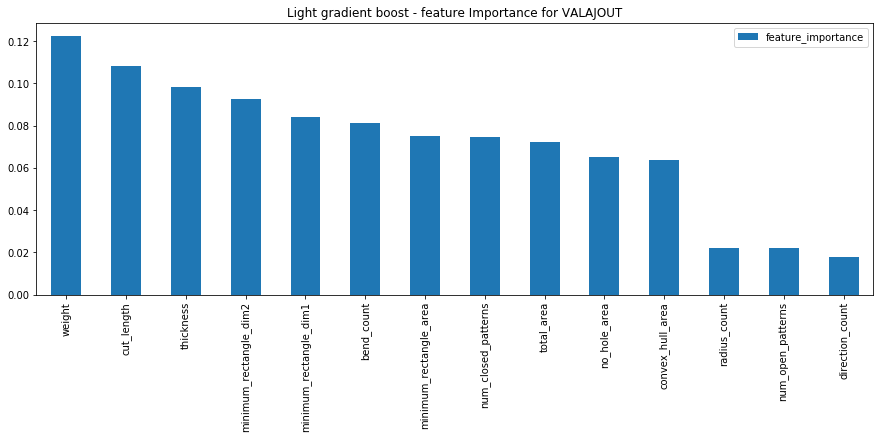

In [47]:
featimp = list(gridxgb.best_estimator_.named_steps['xgb'].feature_importances_)
df = pd.DataFrame({'feature_importance':featimp}, index =limitedset)
df = df.sort_values('feature_importance', ascending=False)
df[:50].plot.bar(figsize=(15,5))
plt.title(f'Light gradient boost - feature Importance for {target}')
plt.show()

# BOX-COX prediction

In [48]:
import xgboost as xgb
xgb1 = xgb.XGBRegressor(random_state=0, n_estimators = 400, n_jobs=-2, eval_metric='mae')
pipe1 = [('scaler', scaler), ('xgb', xgb1)]
regpip1log = Pipeline(pipe1)

## Step 1

In [49]:
%%time
# STEP1
if target == 'VAMAT':
    param_grid = {
        #'xgb__max_depth':range(3,20,2),
        'xgb__max_depth':[3,4,5],
        #'xgb__min_child_weight':range(3,7,2),
        'xgb__min_child_weight':[1,2,3,4,5],
    }
elif target == 'VALAJOUT':
    param_grid = {
        #'xgb__max_depth':range(3,20,2),
        'xgb__max_depth':[3,4,5],
        #'xgb__min_child_weight':range(3,7,2),
        'xgb__min_child_weight':[1,2,3,4,5],
    }
else:
    param_grid = {
        #'xgb__max_depth':range(3,20,2),
        'xgb__max_depth':[3,4,5],
        #'xgb__min_child_weight':range(3,7,2),
        'xgb__min_child_weight':[1,2,3,4,5],
    }
    
gridxgb1log = GridSearchCV(regpip1log, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_absolute_error', verbose=2)
gridxgb1log.fit(X_train[limitedset], y_train['logtarget'])

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] xgb__max_depth=3, xgb__min_child_weight=1 .......................
[CV] xgb__max_depth=3, xgb__min_child_weight=1 .......................
[CV] xgb__max_depth=3, xgb__min_child_weight=1 .......................
[CV] ........ xgb__max_depth=3, xgb__min_child_weight=1, total=   1.2s
[CV] xgb__max_depth=3, xgb__min_child_weight=2 .......................
[CV] ........ xgb__max_depth=3, xgb__min_child_weight=1, total=   1.3s
[CV] xgb__max_depth=3, xgb__min_child_weight=2 .......................
[CV] ........ xgb__max_depth=3, xgb__min_child_weight=1, total=   1.3s
[CV] xgb__max_depth=3, xgb__min_child_weight=2 .......................
[CV] ........ xgb__max_depth=3, xgb__min_child_weight=2, total=   1.3s
[CV] xgb__max_depth=3, xgb__min_child_weight=3 .......................
[CV] ........ xgb__max_depth=3, xgb__min_child_weight=2, total=   1.3s
[CV] xgb__max_depth=3, xgb__min_child_weight=3 .......................
[CV] ........ xg

[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:   20.9s


[CV] ........ xgb__max_depth=5, xgb__min_child_weight=2, total=   2.1s
[CV] xgb__max_depth=5, xgb__min_child_weight=3 .......................
[CV] ........ xgb__max_depth=5, xgb__min_child_weight=3, total=   2.0s
[CV] xgb__max_depth=5, xgb__min_child_weight=4 .......................
[CV] ........ xgb__max_depth=5, xgb__min_child_weight=3, total=   1.9s
[CV] xgb__max_depth=5, xgb__min_child_weight=4 .......................
[CV] ........ xgb__max_depth=5, xgb__min_child_weight=3, total=   2.0s
[CV] xgb__max_depth=5, xgb__min_child_weight=4 .......................
[CV] ........ xgb__max_depth=5, xgb__min_child_weight=4, total=   2.0s
[CV] xgb__max_depth=5, xgb__min_child_weight=5 .......................
[CV] ........ xgb__max_depth=5, xgb__min_child_weight=4, total=   2.0s
[CV] xgb__max_depth=5, xgb__min_child_weight=5 .......................
[CV] ........ xgb__max_depth=5, xgb__min_child_weight=4, total=   1.9s
[CV] xgb__max_depth=5, xgb__min_child_weight=5 .......................
[CV] .

[Parallel(n_jobs=-2)]: Done  45 out of  45 | elapsed:   27.0s finished


CPU times: user 2.51 s, sys: 104 ms, total: 2.61 s
Wall time: 27.7 s


In [50]:
print('target        :', target)
print('best score    :', gridxgb1log.best_score_)
print('best params   :', gridxgb1log.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], inv_boxcox(gridxgb1log.predict(X_test[limitedset]), lmbda))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], inv_boxcox(gridxgb1log.predict(X_test[limitedset]), lmbda))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], inv_boxcox(gridxgb1log.predict(X_train[limitedset]), lmbda))
print('MSE train set :', msetrain)
print()
print('initial params :', xgb1.get_params())

target        : VALAJOUT
best score    : -0.1940109618443822
best params   : {'xgb__max_depth': 4, 'xgb__min_child_weight': 3}
MAPE test set : 20.188188768721243
MSE  test set : 0.5979605689679168
MSE train set : 0.16648779123459878

initial params : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 400, 'n_jobs': -2, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'eval_metric': 'mae'}


## Step 2

In [51]:
# STEP2
if target == 'VAMAT':
    param_grid = {
        'xgb__gamma':np.linspace(0,1,5)
    }
elif target == 'VALAJOUT':
    param_grid = {
        'xgb__gamma':np.linspace(0,1,5)
    }
else:
    param_grid = {
        'xgb__gamma':np.linspace(0,1,5)
    }

    
cleaneddict = {k[5:]:v for k,v in gridxgb1log.best_params_.items()}
mergeddict = {**xgb1.get_params(), **cleaneddict}
xgb2 = xgb.XGBRegressor(**mergeddict)
pipe2 = [('scaler', scaler), ('xgb', xgb2)]
regpip2log = Pipeline(pipe2)
gridxgb2log = GridSearchCV(regpip2log, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_absolute_error', verbose=2)
gridxgb2log.fit(X_train[limitedset], y_train['logtarget'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] xgb__gamma=0.0 ..................................................
[CV] xgb__gamma=0.0 ..................................................
[CV] xgb__gamma=0.0 ..................................................
[CV] ................................... xgb__gamma=0.0, total=   1.6s
[CV] xgb__gamma=0.25 .................................................
[CV] ................................... xgb__gamma=0.0, total=   1.6s
[CV] xgb__gamma=0.25 .................................................
[CV] ................................... xgb__gamma=0.0, total=   1.7s
[CV] xgb__gamma=0.25 .................................................
[CV] .................................. xgb__gamma=0.25, total=   1.4s
[CV] xgb__gamma=0.5 ..................................................
[CV] .................................. xgb__gamma=0.25, total=   1.6s
[CV] xgb__gamma=0.5 ..................................................
[CV] ............

[Parallel(n_jobs=-2)]: Done  15 out of  15 | elapsed:    8.4s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mae', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=4...ate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'xgb__gamma': array([0.  , 0.25, 0.5 , 0.75, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [52]:
print('target        :', target)
print('best score    :', gridxgb2log.best_score_)
print('best params   :', gridxgb2log.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], inv_boxcox(gridxgb2log.predict(X_test[limitedset]), lmbda))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], inv_boxcox(gridxgb2log.predict(X_test[limitedset]), lmbda))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], inv_boxcox(gridxgb2log.predict(X_train[limitedset]), lmbda))
print('MSE train set :', msetrain)
print()
print('initial params :', xgb2.get_params())

target        : VALAJOUT
best score    : -0.1934764951140115
best params   : {'xgb__gamma': 0.25}
MAPE test set : 19.447065437885925
MSE  test set : 0.6424091528163993
MSE train set : 0.3821171421696161

initial params : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 3, 'missing': None, 'n_estimators': 400, 'n_jobs': -2, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'eval_metric': 'mae'}


## Step 3

In [53]:
# STEP3
if target == 'VAMAT':
    param_grid = {
        'xgb__subsample':np.linspace(0.6,1,5),
        'xgb__colsample_bytree':np.linspace(0.6,1,5),
    }
elif target == 'VALAJOUT':
    param_grid = {
        'xgb__subsample':np.linspace(0.6,1,5),
        'xgb__colsample_bytree':np.linspace(0.6,1,5),
    }
else:
    param_grid = {
        'xgb__subsample':np.linspace(0.6,1,5),
        'xgb__colsample_bytree':np.linspace(0.6,1,5),
    }

    
cleaneddict = {k[5:]:v for k,v in gridxgb2log.best_params_.items()}
mergeddict = {**xgb2.get_params(), **cleaneddict}
xgb3 = xgb.XGBRegressor(**mergeddict)
pipe3 = [('scaler', scaler), ('xgb', xgb3)]
regpip3log = Pipeline(pipe3)
gridxgb3log = GridSearchCV(regpip3log, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_absolute_error', verbose=2)
gridxgb3log.fit(X_train[limitedset], y_train['logtarget'])

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.6 ...................
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.6 ...................
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.6 ...................
[CV] .... xgb__colsample_bytree=0.6, xgb__subsample=0.6, total=   1.3s
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.7 ...................
[CV] .... xgb__colsample_bytree=0.6, xgb__subsample=0.6, total=   1.3s
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.7 ...................
[CV] .... xgb__colsample_bytree=0.6, xgb__subsample=0.6, total=   1.6s
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.7 ...................
[CV] .... xgb__colsample_bytree=0.6, xgb__subsample=0.7, total=   1.3s
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.8 ...................
[CV] .... xgb__colsample_bytree=0.6, xgb__subsample=0.7, total=   1.4s
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.8 ...................
[CV] .... xgb__c

[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:   16.2s


[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.7, total=   1.4s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=0.8 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.8, total=   1.4s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=0.9 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.8, total=   1.4s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=0.9 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.8, total=   1.5s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=0.9 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.9, total=   1.3s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=1.0 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.9, total=   1.4s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=1.0 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.9, total=   1.5s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=1.0 ...................
[CV] .

[Parallel(n_jobs=-2)]: Done  75 out of  75 | elapsed:   35.6s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mae', gamma=0.25,
       learning_rate=0.1, max_delta_step=0, max_dept...reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'xgb__subsample': array([0.6, 0.7, 0.8, 0.9, 1. ]), 'xgb__colsample_bytree': array([0.6, 0.7, 0.8, 0.9, 1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [54]:
print('target        :', target)
print('best score    :', gridxgb3log.best_score_)
print('best params   :', gridxgb3log.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], inv_boxcox(gridxgb3log.predict(X_test[limitedset]), lmbda))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], inv_boxcox(gridxgb3log.predict(X_test[limitedset]), lmbda))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], inv_boxcox(gridxgb3log.predict(X_train[limitedset]), lmbda))
print('MSE train set :', msetrain)
print()
print('initial params :', xgb3.get_params())

target        : VALAJOUT
best score    : -0.19239224406052205
best params   : {'xgb__colsample_bytree': 0.6, 'xgb__subsample': 1.0}
MAPE test set : 19.724918064179022
MSE  test set : 0.6565604467064947
MSE train set : 0.3404553909512824

initial params : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.25, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 3, 'missing': None, 'n_estimators': 400, 'n_jobs': -2, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'eval_metric': 'mae'}


## Step 4

In [55]:
# STEP4
if target == 'VAMAT':
    param_grid = {
        #'xgb__reg_alpha':np.logspace(-3,3,5),
        'xgb__reg_alpha':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
        #'xgb__reg_lambda':np.logspace(-3,3,5),
        'xgb__reg_lambda':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
                }
elif target == 'VALAJOUT':
    param_grid = {
        #'xgb__reg_alpha':np.logspace(-3,3,5),
        'xgb__reg_alpha':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
        #'xgb__reg_lambda':np.logspace(-3,3,5),
        'xgb__reg_lambda':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
                }
else:
    param_grid = {
        #'xgb__reg_alpha':np.logspace(-3,3,5),
        'xgb__reg_alpha':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
        #'xgb__reg_lambda':np.logspace(-3,3,5),
        'xgb__reg_lambda':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
                }

    
cleaneddict = {k[5:]:v for k,v in gridxgb3log.best_params_.items()}
mergeddict = {**xgb3.get_params(), **cleaneddict}
xgb4 = xgb.XGBRegressor(**mergeddict)
pipe4 = [('scaler', scaler), ('xgb', xgb4)]
regpip4log = Pipeline(pipe4)
gridxgb4log = GridSearchCV(regpip4log, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_absolute_error', verbose=2)
gridxgb4log.fit(X_train[limitedset], y_train['logtarget'])

Fitting 3 folds for each of 49 candidates, totalling 147 fits
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.001 .....................
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.001 .....................
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.001 .....................
[CV] ...... xgb__reg_alpha=0.001, xgb__reg_lambda=0.001, total=   1.2s
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.01 ......................
[CV] ...... xgb__reg_alpha=0.001, xgb__reg_lambda=0.001, total=   1.3s
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.01 ......................
[CV] ...... xgb__reg_alpha=0.001, xgb__reg_lambda=0.001, total=   1.3s
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.01 ......................
[CV] ....... xgb__reg_alpha=0.001, xgb__reg_lambda=0.01, total=   1.2s
[CV] ....... xgb__reg_alpha=0.001, xgb__reg_lambda=0.01, total=   1.3s
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.1 .......................
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.1 .......................
[CV] ....... xg

[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:   15.1s


[CV] ........... xgb__reg_alpha=0.01, xgb__reg_lambda=1, total=   1.2s
[CV] xgb__reg_alpha=0.01, xgb__reg_lambda=100.0 ......................
[CV] ....... xgb__reg_alpha=0.01, xgb__reg_lambda=100.0, total=   1.1s
[CV] xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0 .....................
[CV] ....... xgb__reg_alpha=0.01, xgb__reg_lambda=100.0, total=   1.2s
[CV] xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0 .....................
[CV] ....... xgb__reg_alpha=0.01, xgb__reg_lambda=100.0, total=   1.2s
[CV] xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0 .....................
[CV] ...... xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0, total=   1.2s
[CV] xgb__reg_alpha=0.1, xgb__reg_lambda=0.001 .......................
[CV] ...... xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0, total=   1.1s
[CV] xgb__reg_alpha=0.1, xgb__reg_lambda=0.001 .......................
[CV] ...... xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0, total=   1.2s
[CV] xgb__reg_alpha=0.1, xgb__reg_lambda=0.001 .......................
[CV] .

[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=0, total=   1.3s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=1 .............................
[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=0, total=   1.2s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=1 .............................
[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=0, total=   1.2s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=1 .............................
[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=1, total=   1.2s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=100.0 .........................
[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=1, total=   1.4s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=100.0 .........................
[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=1, total=   1.2s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=100.0 .........................
[CV] .......... xgb__reg_alpha=1, xgb__reg_lambda=100.0, total=   1.2s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=1000.0 ........................
[CV] .

[Parallel(n_jobs=-2)]: Done 147 out of 147 | elapsed:   55.0s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='mae', gamma=0.25,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=3, mis...eg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1.0))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'xgb__reg_alpha': [0.001, 0.01, 0.1, 0, 1, 100.0, 1000.0], 'xgb__reg_lambda': [0.001, 0.01, 0.1, 0, 1, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [56]:
print('target        :', target)
print('best score    :', gridxgb4log.best_score_)
print('best params   :', gridxgb4log.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], inv_boxcox(gridxgb4log.predict(X_test[limitedset]), lmbda))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], inv_boxcox(gridxgb4log.predict(X_test[limitedset]), lmbda))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], inv_boxcox(gridxgb4log.predict(X_train[limitedset]), lmbda))
print('MSE train set :', msetrain)
print()
print('initial params :', xgb4.get_params())

target        : VALAJOUT
best score    : -0.19239224406052205
best params   : {'xgb__reg_alpha': 0, 'xgb__reg_lambda': 1}
MAPE test set : 19.724918064179022
MSE  test set : 0.6565604467064947
MSE train set : 0.3404553909512824

initial params : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.6, 'gamma': 0.25, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 3, 'missing': None, 'n_estimators': 400, 'n_jobs': -2, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1.0, 'eval_metric': 'mae'}


## Step 5

In [57]:
# STEP5

if target == 'VAMAT':
    param_grid = {
        'xgb__learning_rate':[.01, .05, .001],
                }
elif target == 'VALAJOUT':
    param_grid = {
        'xgb__learning_rate':[.01, .05, .001],
                }
else:
    param_grid = {
        'xgb__learning_rate':[.01, .05, .001],
                }

    
cleaneddict = {k[5:]:v for k,v in gridxgb4log.best_params_.items()}
mergeddict = {**xgb4.get_params(), **cleaneddict}
xgb5 = xgb.XGBRegressor(**mergeddict)
pipe5 = [('scaler', scaler), ('xgb', xgb5)]
regpip5log = Pipeline(pipe5)
gridxgblog = GridSearchCV(regpip5log, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_absolute_error', verbose=2)
gridxgblog.fit(X_train[limitedset], y_train['logtarget'])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] xgb__learning_rate=0.01 .........................................
[CV] xgb__learning_rate=0.01 .........................................
[CV] xgb__learning_rate=0.01 .........................................
[CV] .......................... xgb__learning_rate=0.01, total=   1.2s
[CV] .......................... xgb__learning_rate=0.01, total=   1.2s
[CV] xgb__learning_rate=0.05 .........................................
[CV] xgb__learning_rate=0.05 .........................................
[CV] .......................... xgb__learning_rate=0.01, total=   1.5s
[CV] xgb__learning_rate=0.05 .........................................
[CV] .......................... xgb__learning_rate=0.05, total=   1.2s
[CV] xgb__learning_rate=0.001 ........................................
[CV] .......................... xgb__learning_rate=0.05, total=   1.3s
[CV] xgb__learning_rate=0.001 ........................................
[CV] .............

[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed:    4.0s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='mae', gamma=0.25,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=3, mis...eg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1.0))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'xgb__learning_rate': [0.01, 0.05, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [58]:
print('target        :', target)
print('best score    :', gridxgblog.best_score_)
print('best params   :', gridxgblog.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], inv_boxcox(gridxgblog.predict(X_test[limitedset]), lmbda))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], inv_boxcox(gridxgblog.predict(X_test[limitedset]), lmbda))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], inv_boxcox(gridxgblog.predict(X_train[limitedset]), lmbda))
print('MSE train set :', msetrain)
print()
print('initial params :', xgb5.get_params())

target        : VALAJOUT
best score    : -0.1926485011853063
best params   : {'xgb__learning_rate': 0.05}
MAPE test set : 19.183928721303563
MSE  test set : 0.6406975307443294
MSE train set : 0.35305146772379603

initial params : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.6, 'gamma': 0.25, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 3, 'missing': None, 'n_estimators': 400, 'n_jobs': -2, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1.0, 'eval_metric': 'mae'}


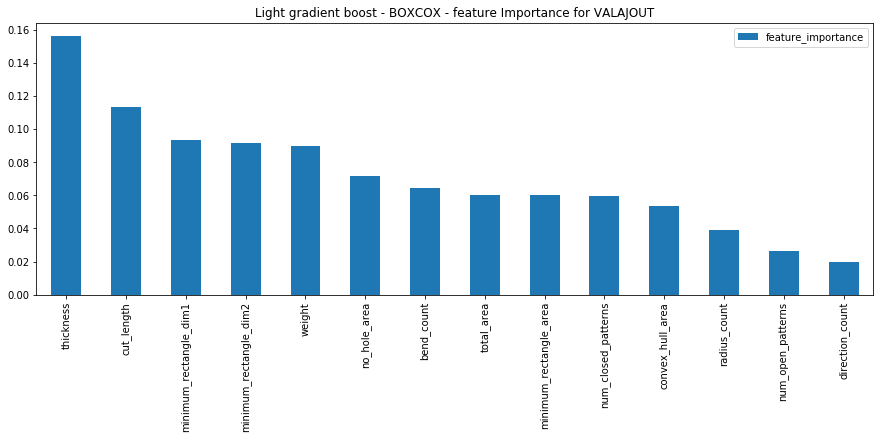

In [59]:
featimp = list(gridxgblog.best_estimator_.named_steps['xgb'].feature_importances_)
df = pd.DataFrame({'feature_importance':featimp}, index =limitedset)
df = df.sort_values('feature_importance', ascending=False)
df[:50].plot.bar(figsize=(15,5))
plt.title(f'Light gradient boost - BOXCOX - feature Importance for {target}')
plt.show()

# Solution comparison

In [60]:
prediction_xgb = gridxgb.predict(X_test[limitedset])
prediction_xgb_log = inv_boxcox(gridxgblog.predict(X_test[limitedset]), lmbda)

In [61]:
resultset = pd.DataFrame({f'target': y_test[target],
                          'prediction_xgb':prediction_xgb,
                          'prediction_xgb_log':prediction_xgb_log,
                            }, index=y_test.index)
resultset.head()

,prediction_xgb,prediction_xgb_log,target
COART,,,
L1614870,1.050541,0.892949,1.10
L7052470,2.445297,2.386759,2.26
L7069450,4.963526,4.509463,5.16
L7056570,1.559444,1.469221,1.60
L7055980,4.552634,4.270194,4.54


In [62]:
#Solution saving
resultset.to_csv(f'{target}_pred_xgb.csv')


In [63]:
#MAPE
mape = mean_absolute_percentage_error(resultset['target'], resultset['prediction_xgb'])
mapelog = mean_absolute_percentage_error(resultset['target'], resultset['prediction_xgb_log'])
print('mape', mape)
print('mapelog', mapelog)

mape 20.252939684332432
mapelog 19.183928721303563


In [64]:
#MSE
mse = mean_squared_error(resultset['target'], resultset['prediction_xgb'])
mselog = mean_squared_error(resultset['target'], resultset['prediction_xgb_log'])
print('mse', mse)
print('mselog', mselog)

mse 0.6107602330965155
mselog 0.6406975307443294


In [65]:
resultset['MSE_xgb'] = (resultset['target']-resultset['prediction_xgb'])**2
resultset['MSE_log_xgb'] = (resultset['target']-resultset['prediction_xgb_log'])**2
resultset.head()

,prediction_xgb,prediction_xgb_log,target,MSE_xgb,MSE_log_xgb
COART,,,,,
L1614870,1.050541,0.892949,1.10,0.002446,0.042870
L7052470,2.445297,2.386759,2.26,0.034335,0.016068
L7069450,4.963526,4.509463,5.16,0.038602,0.423198
L7056570,1.559444,1.469221,1.60,0.001645,0.017103
L7055980,4.552634,4.270194,4.54,0.000160,0.072796


In [66]:
resultset['MSE_xgb'].mean()

0.6107602330965155

In [67]:
#Data assembly
comparisonset = pd.merge(resultset.reset_index(), X_test.reset_index(), on='COART', how='inner')
comparisonset.head()

,COART,prediction_xgb,prediction_xgb_log,target,MSE_xgb,MSE_log_xgb,cut_length,num_closed_patterns,num_open_patterns,total_area,...,weight,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group,SURF_COST_MPATTERN,APPROX_BEND_COST
0,L1614870,1.050541,0.892949,1.10,0.002446,0.042870,491.239319,3,0,5183.537598,...,0.696397,0.60,1.10,1.70,0.000009,0.000007,0.000014,0,0.000109,1.100000
1,L7052470,2.445297,2.386759,2.26,0.034335,0.016068,1964.522949,5,0,56573.984375,...,5.803608,4.55,2.26,6.81,0.000011,0.000006,0.000012,0,0.000070,2.260000
2,L7069450,4.963526,4.509463,5.16,0.038602,0.423198,1373.007935,10,0,45724.308594,...,3.531498,3.36,5.16,8.52,0.000010,0.000007,0.000012,6+,0.000070,0.737143
3,L7056570,1.559444,1.469221,1.60,0.001645,0.017103,473.709930,2,0,9852.923828,...,0.317028,0.30,1.60,1.90,0.000007,0.000007,0.000007,1-2,0.000030,0.533333
4,L7055980,4.552634,4.270194,4.54,0.000160,0.072796,1868.538208,5,0,42290.605469,...,3.894105,4.20,4.54,8.74,0.000011,0.000008,0.000012,3-5,0.000097,1.135000


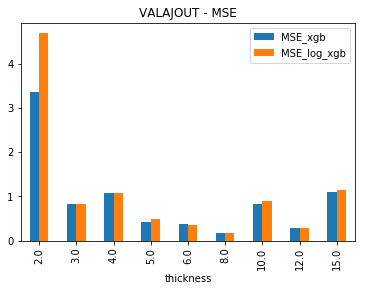

,MSE_xgb,MSE_log_xgb,COART
,mean,mean,count
thickness,,,
2.0,3.376306,4.697023,21
3.0,0.819796,0.840319,127
4.0,1.081994,1.076255,189
5.0,0.415112,0.480048,169
6.0,0.381483,0.346322,319
8.0,0.181065,0.174925,242
10.0,0.830301,0.899126,190
12.0,0.279932,0.274373,90


In [68]:
# Is the error sourced by thickness ?
df = comparisonset[['MSE_xgb', 'MSE_log_xgb', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.show()
comparisonset.groupby('thickness').agg({'MSE_xgb':['mean'],
                                        'MSE_log_xgb':['mean'],
                                         'COART':['count']})

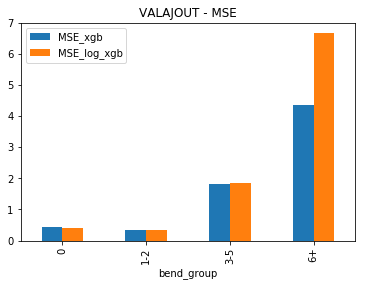

,MSE_xgb,MSE_log_xgb,COART
,mean,mean,count
bend_group,,,
0,0.421634,0.415021,583
1-2,0.332499,0.335309,619
3-5,1.830507,1.845842,176
6+,4.379032,6.668436,18


In [69]:
# Is the error sourced by number of errors ?

df = comparisonset[['MSE_xgb', 'MSE_log_xgb', 'bend_group']].groupby('bend_group').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.show()
comparisonset.groupby('bend_group').agg({'MSE_xgb':['mean'],
                                         'MSE_log_xgb':['mean'],
                                         'COART':['count']})

In [70]:
comparisonset['MAPE_error'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['prediction_xgb']), axis=1)
comparisonset['MAPE_log_error'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['prediction_xgb_log']), axis=1)

comparisonset[['target', 'prediction_xgb', 'MAPE_error', 'prediction_xgb_log', 'MAPE_log_error']].head()

,target,prediction_xgb,MAPE_error,prediction_xgb_log,MAPE_log_error
0,1.10,1.050541,4.496236,0.892949,18.822792
1,2.26,2.445297,8.198993,2.386759,5.608807
2,5.16,4.963526,3.807640,4.509463,12.607300
3,1.60,1.559444,2.534775,1.469221,8.173718
4,4.54,4.552634,0.278287,4.270194,5.942873


In [71]:
#MAPE
print('MAPE', comparisonset['MAPE_error'].mean())
print('MAPE log', comparisonset['MAPE_log_error'].mean())

MAPE 20.252939684332446
MAPE log 19.183928721303538


In [72]:
#If bends use this line
if target == 'VALAJOUT' or target == 'VALTOT':
    df = comparisonset[['MSE_xgb', 'MSE_log_xgb','MAPE_error', 'MAPE_log_error', 'thickness', 'bend_group', 'COART']].groupby(['thickness', 'bend_group'])

#If no bends use this line
if target == 'VAMAT':
    df = comparisonset[['MSE_xgb', 'MSE_log_xgb','MAPE_error', 'MAPE_log_error', 'thickness', 'COART']].groupby(['thickness'])

df.agg({'MSE_xgb': ['mean', 'max'],
        'MSE_log_xgb': ['mean', 'max'],
        'MAPE_error': ['mean', 'max'],
        'MAPE_log_error': ['mean', 'max'],
        'COART':['count'] })

MSE_xgb            MSE_log_xgb            MAPE_error  \
                          mean        max        mean        max       mean   
thickness bend_group                                                          
2.0       0           0.608526   1.129774    0.249622   0.424281  78.065334   
          1-2         1.220508   8.588712    0.960100   6.008944  25.937493   
          3-5         3.174982   8.819374    4.625652  16.552191  16.529147   
          6+          9.424107  25.210273   14.519471  35.469311  32.526877   
3.0       0           0.442338   4.552129    0.451994   7.104022  34.048257   
          1-2         0.196234   1.672827    0.167304   1.932726  14.664583   
          3-5         1.849625  11.731983    1.830637  11.282457  21.160884   
          6+          2.175325   5.987584    3.074261  12.093033   9.439454   
4.0       0           0.272853   2.230752    0.349167   3.341377  35.638814   
          1-2         0.269842   4.397569    0.286273   5.830405  20.465175   
          3-5         3.703311  38.912451    3.567427  38.706235  31.267999   
          6+          1.438234   2.867431    1.842229   3.681328  13.301817   
5.0       0           0.264945   2.217043    0.210437   2.442425  39.464243   
          1-2         0.195006   1.963151    0.186774   1.901625  14.728219   
          3-5         0.597285   6.814201    0.538167   6.077337  12.580998   
          6+          4.262695  17.007637    7.580754  35.691793  13.534975   
6.0       0           0.262083  12.487538    0.260078  13.025207  25.969149   
          1-2         0.358818  10.174817    0.307338   7.014034  15.913287   
          3-5         0.875387   4.996893    0.814476   4.797550  23.753099   
          6+          3.029790   6.020977    2.497218   4.571239  15.153107   
8.0       0           0.183666   3.656521    0.161356   3.790971  17.495163   
          1-2         0.176696   3.129545    0.178923   3.107724   9.950553   
          3-5         0.188543   1.754515    0.229888   1.930702   5.187606   
10.0      0           0.789600  15.045663    0.778655  12.905655  21.007092   
          1-2         0.684195  11.617602    0.852962  22.232995   9.596166   
          3-5         3.917305  10.438638    4.241931  10.152089  15.992541   
12.0      0           0.198785   3.017212    0.198369   3.612427  18.244606   
          1-2         0.472277   1.934405    0.465646   2.052238  54.538638   
          3-5         0.938188   0.938188    0.624075   0.624075  26.464510   
15.0      0           1.264159  12.697198    1.301176  13.573028  20.211019   
          1-2         0.315287   1.462713    0.247311   1.286201  13.651755   
          3-5         0.454426   0.454426    1.100332   1.100332  13.322351   

                                 MAPE_log_error             COART  
                             max           mean         max count  
thickness bend_group                                               
2.0       0           122.173367      53.170180   74.869984     2  
          1-2         119.618389      25.210349  100.053663     8  
          3-5          34.200554      20.176314   38.454050     7  
          6+           77.965579      37.666498   92.478444     4  
3.0       0           226.042771      28.170369  184.623666    33  
          1-2          94.131436      14.046831  113.026438    52  
          3-5          92.765710      20.774550   86.954272    37  
          6+           15.011988       8.635605   20.360093     5  
4.0       0           112.839170      26.798783   84.162443    29  
          1-2         211.784033      20.302629  203.733997   114  
          3-5         126.687202      27.359478  100.699681    44  
          6+           24.865623      14.598515   28.174432     2  
5.0       0           241.850271      36.802789  224.576100    57  
          1-2          65.671127      14.178041   56.938694    75  
          3-5          96.967859      11.877198   94.816369    32  
          6+           22.681383 

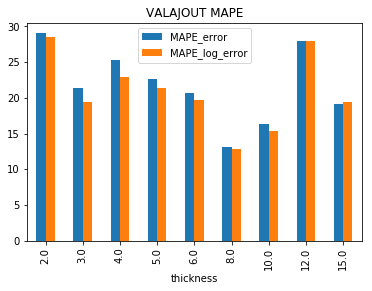

,MAPE_error,MAPE_log_error,COART
,mean,mean,count
thickness,,,
2.0,29.021055,28.567778,21
3.0,21.388195,19.463730,127
4.0,25.232546,22.881897,189
5.0,22.629261,21.314427,169
6.0,20.694655,19.737042,319
8.0,13.153664,12.821354,242
10.0,16.370817,15.327005,190
12.0,28.014347,27.976429,90


In [73]:
df = comparisonset[['MAPE_error', 'MAPE_log_error', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} MAPE')
plt.show()
comparisonset.groupby('thickness').agg({'MAPE_error':['mean'],
                                         'MAPE_log_error':['mean'],
                                         'COART':['count']})

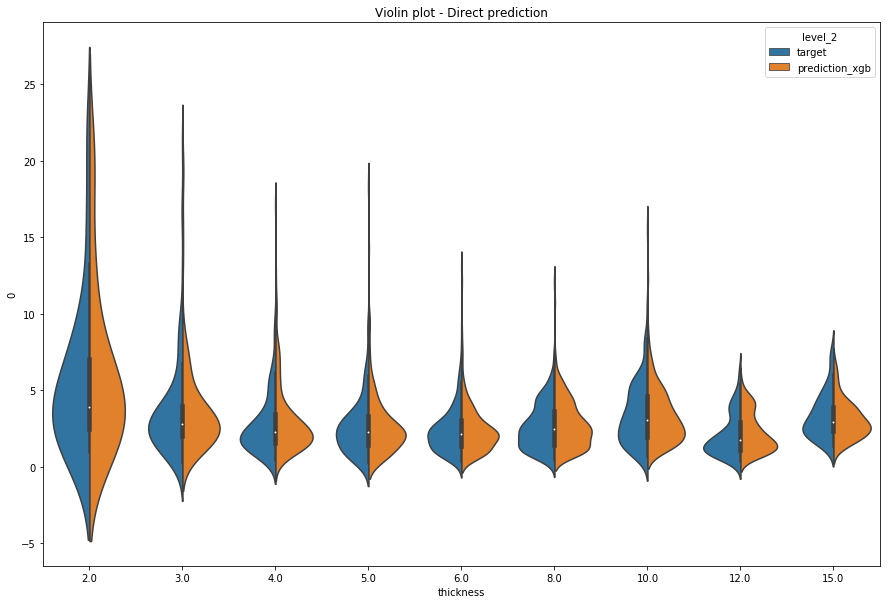

In [74]:
#Violin plot
df=comparisonset[['target', 'prediction_xgb', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
#ax.set_ylim(-100, 100)
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)
plt.title('Violin plot - Direct prediction')
plt.show()

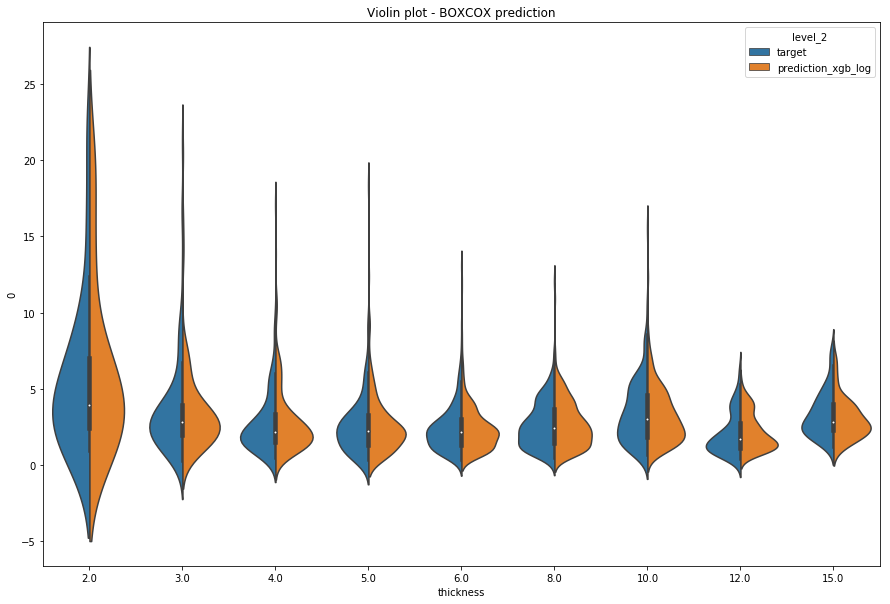

In [75]:
#Violin plot
df=comparisonset[['target', 'prediction_xgb_log', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
#ax.set_ylim(-100, 100)
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)
plt.title('Violin plot - BOXCOX prediction')
plt.show()

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


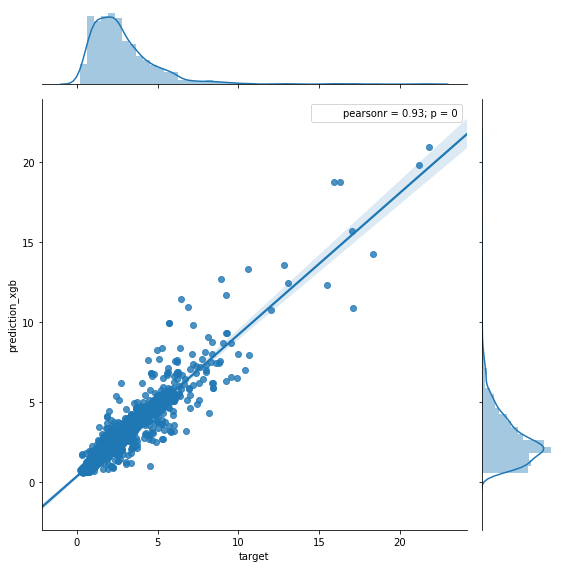

In [76]:
# No BOXCOX
sns.jointplot(x='target', y='prediction_xgb', data=comparisonset, kind='reg', size=8)
plt.show()

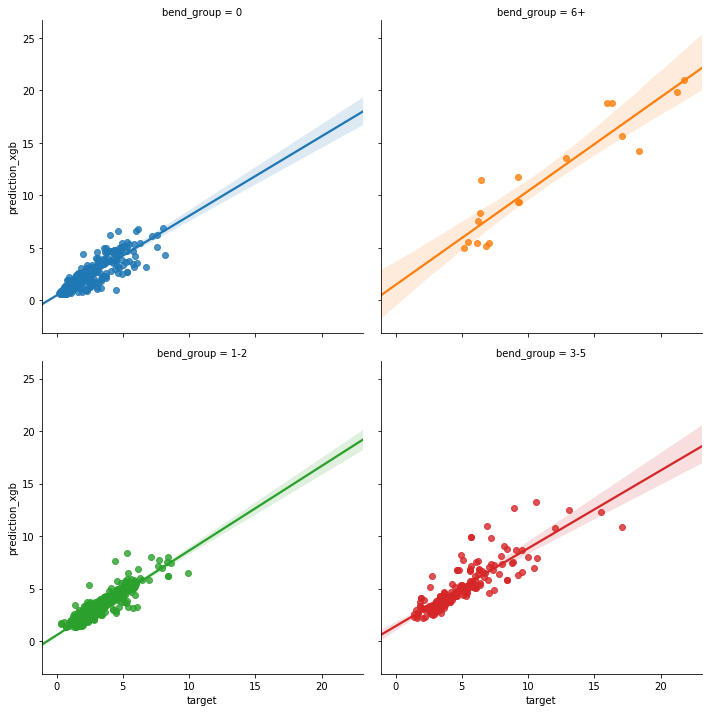

In [77]:
sns.lmplot(x='target',
           y='prediction_xgb',
           col='bend_group',
           hue='bend_group',
           data=comparisonset,
           aspect=1,
           col_wrap=2,
           size=5,
           legend=True)
plt.show()

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


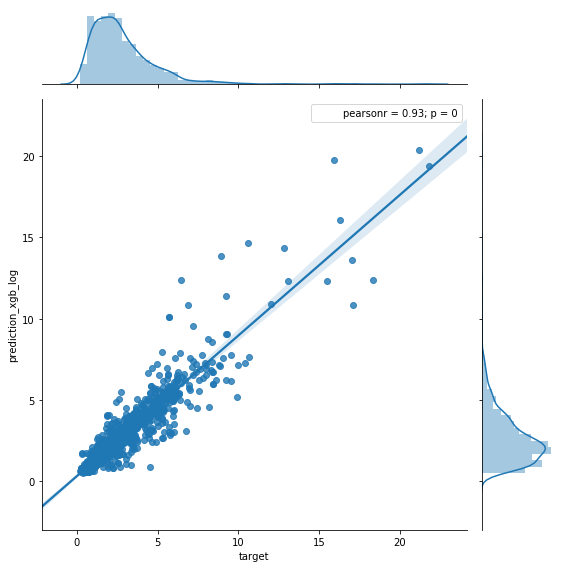

In [78]:
# With BOXCOX
sns.jointplot(x='target', y='prediction_xgb_log', data=comparisonset, kind='reg',size=8)
plt.show()

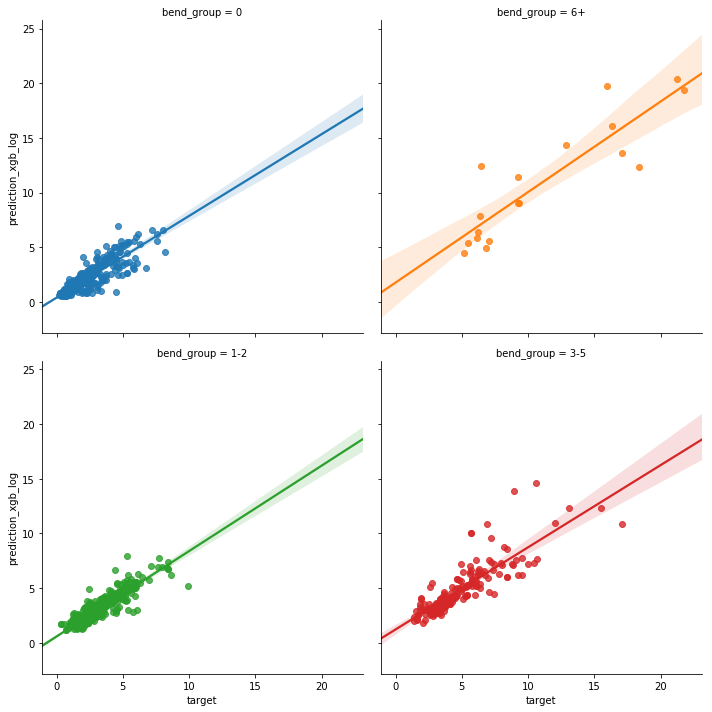

In [79]:
sns.lmplot(x='target',
           y='prediction_xgb_log',
           col='bend_group',
           hue='bend_group',
           data=comparisonset,
           aspect=1,
           col_wrap=2,
           size=5,
           #palette="Set1",
           legend=True),
plt.show()

In [80]:
df = comparisonset[['MSE_xgb', 'COART', 'thickness']]
df.set_index('COART', inplace=True)
worst = df.groupby('thickness')['MSE_xgb'].nlargest(5)

worst.to_csv('../Y3 - Sample data/Z3 - outliers.csv')
print(worst.shape)
worst

(45,)


thickness  COART   
2.0        L7067210    25.210273
           L6019240     8.819374
           L7067200     8.588712
           L5701460     7.971701
           L2503310     7.341712
3.0        L8051761    11.731983
           L2513140     8.750984
           L1608120     6.585988
           L1608130     6.585988
           L6703390     6.476967
4.0        L8838710    38.912451
           L8815170    17.666619
           L8815160    17.498892
           L8818570    16.536692
           L1608630    13.943589
5.0        L7065870    17.007637
           L7072760     6.814201
           L3100190     6.356270
           L8828280     2.549672
           L2608250     2.217043
6.0        L2611660    12.487538
           L8035060    10.174817
           L8035050     9.508577
           L3107181     6.020977
           L8818480     4.996893
8.0        L2522320     3.656521
           L7034960     3.129545
           L2608230     2.784789
           L7080990     2.354998
           L3039800    

In [81]:
#comparison

#Thickness filter
df = comparisonset[comparisonset['thickness'] == 4]

#Cost filter Max
#df = df[df[target]<15]

#Cost filter Min
#df = df[df[target]>10] #bend_count

#Min rectangle area
#df = df[df['minimum_rectangle_area'] < 700000]
df = df[df['minimum_rectangle_area'] > 1e+06]

#bend_count filter
df = df[df['bend_count'] == 4]

#df[df['COART']=='L3128890'].T
df.T

,331,357,1026
COART,L8815170,L1608630,L8815160
prediction_xgb,9.90317,12.6841,9.90317
prediction_xgb_log,10.0804,13.8582,10.0804
target,5.7,8.95,5.72
MSE_xgb,17.6666,13.9436,17.4989
MSE_log_xgb,19.1882,24.0903,19.0134
cut_length,5265.08,7774,5265.08
num_closed_patterns,2,1,2
num_open_patterns,0,0,0
total_area,905130,2.72349e+06,905130


In [82]:
dataset.loc[['L1608630']].T
#comparisonset[comparisonset['COART'] == 'L3131690']

COART,L1608630
cut_length,7774
num_closed_patterns,1
num_open_patterns,0
total_area,2.72349e+06
minimum_rectangle_area,2.72349e+06
minimum_rectangle_dim1,2970
minimum_rectangle_dim2,917
convex_hull_area,2.72349e+06
no_hole_area,2.72349e+06
thickness,4


# Hyper Opt

In [83]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score

https://github.com/hyperopt/hyperopt/wiki/FMin

## Direct prediction

In [84]:
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'min_child_weight':params['min_child_weight'],
        'gamma':params['gamma'],
        'subsample':params['subsample'],
        'colsample_bytree':params['colsample_bytree'],
        'reg_alpha':params['reg_alpha'],
        'reg_lambda':params['reg_lambda'],
        'learning_rate':params['learning_rate'],
        }
    
    clf = xgb.XGBRegressor(n_jobs=-2,
                           **params,
                            )
    
    pipe = [('scaler', scaler), ('xgb', clf)]
    regpip = Pipeline(pipe)
    
    score = cross_val_score(regpip, X_train[limitedset], y_train[target], scoring='neg_mean_squared_error', cv=3).mean()
    #score = cross_val_score(regpip, X_train[limitedset], y_train['logtarget'], scoring='neg_mean_squared_error', cv=3).mean()
    print("MSE {:.3f} params {}".format(score, params))
    return -score

space = {
    'n_estimators': hp.uniform('n_estimators', 100, 500),
    'max_depth': hp.uniform('max_depth', 3, 8),
    'min_child_weight': hp.uniform('min_child_weight', 0, 10),
    'gamma':hp.uniform('gamma', 0, 1e2),
    'subsample':hp.uniform('subsample', .5, 1.),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', -1, 1),
    'reg_lambda': hp.loguniform('reg_lambda', -1, 1),
    'learning_rate': hp.uniform('learning_rate', 0.001, .2),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100)

MSE -1.031 params {'n_estimators': 268, 'max_depth': 4, 'min_child_weight': 0.43483980750321005, 'gamma': 95.81777079356611, 'subsample': 0.8003761013596747, 'colsample_bytree': 0.8887647752738922, 'reg_alpha': 1.3983909219076418, 'reg_lambda': 1.5330872174547476, 'learning_rate': 0.01312633036089093}
MSE -0.972 params {'n_estimators': 203, 'max_depth': 4, 'min_child_weight': 0.5864090795114651, 'gamma': 77.06574528978007, 'subsample': 0.6266482496299048, 'colsample_bytree': 0.6726034394103944, 'reg_alpha': 0.77064297355516, 'reg_lambda': 1.1927789647649052, 'learning_rate': 0.05188553053813133}
MSE -0.633 params {'n_estimators': 451, 'max_depth': 7, 'min_child_weight': 2.8879627774606265, 'gamma': 5.120111280171303, 'subsample': 0.739450853262541, 'colsample_bytree': 0.9319437274116962, 'reg_alpha': 1.0077712831046426, 'reg_lambda': 0.5614991327726426, 'learning_rate': 0.13419104935955228}
MSE -0.890 params {'n_estimators': 123, 'max_depth': 4, 'min_child_weight': 0.4301099208929404, 

MSE -0.758 params {'n_estimators': 287, 'max_depth': 4, 'min_child_weight': 1.0775996362993174, 'gamma': 0.10123658272836877, 'subsample': 0.6106980377065662, 'colsample_bytree': 0.877437880062501, 'reg_alpha': 1.2095371950375493, 'reg_lambda': 0.41778155650655197, 'learning_rate': 0.010355048147812643}
MSE -0.700 params {'n_estimators': 410, 'max_depth': 4, 'min_child_weight': 0.22996565539684077, 'gamma': 13.094924168892451, 'subsample': 0.5052026573019475, 'colsample_bytree': 0.8835091072268197, 'reg_alpha': 1.5107528410027105, 'reg_lambda': 0.45344627059402903, 'learning_rate': 0.07432339289691389}
MSE -0.987 params {'n_estimators': 359, 'max_depth': 3, 'min_child_weight': 0.9225165187166859, 'gamma': 86.64403717367473, 'subsample': 0.6291566964777914, 'colsample_bytree': 0.9625989227284867, 'reg_alpha': 2.162912663832004, 'reg_lambda': 0.6102716744502424, 'learning_rate': 0.023306156921804225}
MSE -0.759 params {'n_estimators': 362, 'max_depth': 3, 'min_child_weight': 1.6523889476

MSE -0.759 params {'n_estimators': 180, 'max_depth': 3, 'min_child_weight': 2.321004072630833, 'gamma': 15.401898250652692, 'subsample': 0.5445255997215446, 'colsample_bytree': 0.613827740404118, 'reg_alpha': 1.8277814355936592, 'reg_lambda': 0.6641030074793273, 'learning_rate': 0.16734502875379642}
MSE -0.841 params {'n_estimators': 446, 'max_depth': 3, 'min_child_weight': 9.935477820145513, 'gamma': 42.263513898002856, 'subsample': 0.8410304961125799, 'colsample_bytree': 0.5751980895630604, 'reg_alpha': 0.780624469792083, 'reg_lambda': 0.5049194790464058, 'learning_rate': 0.11430053342373962}
MSE -3.532 params {'n_estimators': 498, 'max_depth': 4, 'min_child_weight': 0.4297502305790235, 'gamma': 36.568153498375416, 'subsample': 0.5763007066482229, 'colsample_bytree': 0.8205049850905584, 'reg_alpha': 1.3784557224532126, 'reg_lambda': 0.45226238510921696, 'learning_rate': 0.0013381294288171836}
MSE -0.639 params {'n_estimators': 315, 'max_depth': 4, 'min_child_weight': 7.62139088145481

MSE -0.636 params {'n_estimators': 386, 'max_depth': 4, 'min_child_weight': 3.94579044888767, 'gamma': 5.592345472501092, 'subsample': 0.5210894548575014, 'colsample_bytree': 0.9387355674375375, 'reg_alpha': 0.961529857210838, 'reg_lambda': 0.3710422049595365, 'learning_rate': 0.04048418675090438}
MSE -0.782 params {'n_estimators': 272, 'max_depth': 5, 'min_child_weight': 0.01624583221375442, 'gamma': 29.31114297523885, 'subsample': 0.6561381772892861, 'colsample_bytree': 0.8988979246416706, 'reg_alpha': 1.3577819658875099, 'reg_lambda': 1.5458112655191403, 'learning_rate': 0.07671209046702963}
MSE -0.859 params {'n_estimators': 469, 'max_depth': 5, 'min_child_weight': 9.287326894179408, 'gamma': 55.095692949931895, 'subsample': 0.7489903209647392, 'colsample_bytree': 0.7160375880185028, 'reg_alpha': 0.8163978373404774, 'reg_lambda': 0.5367808783539778, 'learning_rate': 0.09497404300610188}
MSE -0.763 params {'n_estimators': 455, 'max_depth': 3, 'min_child_weight': 4.685145111402353, '

In [85]:
params = {
        'n_estimators': int(best['n_estimators']),
        'max_depth': int(best['max_depth']),
        'min_child_weight':best['min_child_weight'],
        'gamma':best['gamma'],
        'subsample':best['subsample'],
        'colsample_bytree':best['colsample_bytree'],
        'reg_alpha':best['reg_alpha'],
        'reg_lambda':best['reg_lambda'],
        'learning_rate':best['learning_rate'],
        }

clf = xgb.XGBRegressor(n_jobs=-2, **params,)
pipe = [('scaler', scaler), ('xgb', clf)]
regpip = Pipeline(pipe)
regpip.fit(X_train[limitedset], y_train[target])
msetest = mean_squared_error(y_test[target], regpip.predict(X_test[limitedset]))
mapetest = mean_absolute_percentage_error(y_test[target], regpip.predict(X_test[limitedset]))
msetrain = mean_squared_error(y_train[target], regpip.predict(X_train[limitedset]))
#print(clf.get_params())
print(params)
print('MSE  test:', msetest)
print('MSE train:', msetrain)
print('MAPE test:', mapetest)


{'n_estimators': 423, 'max_depth': 3, 'min_child_weight': 1.4667636900992136, 'gamma': 1.0739446237383072, 'subsample': 0.7075887497400182, 'colsample_bytree': 0.9944116662908131, 'reg_alpha': 1.0844565865400944, 'reg_lambda': 0.4925426520415443, 'learning_rate': 0.08875484083736009}
MSE  test: 0.6605903699325236
MSE train: 0.26201218344319455
MAPE test: 20.606700856675218


## BOX-COX

In [86]:
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'min_child_weight':params['min_child_weight'],
        #'gamma':params['gamma'],
        'subsample':params['subsample'],
        'colsample_bytree':params['colsample_bytree'],
        'reg_alpha':params['reg_alpha'],
        'reg_lambda':params['reg_lambda'],
        'learning_rate':params['learning_rate'],
        }
    
    clf = xgb.XGBRegressor(n_jobs=-2,
                           **params,
                            )
    
    pipe = [('scaler', scaler), ('xgb', clf)]
    regpip = Pipeline(pipe)
    
    #score = cross_val_score(regpip, X_train[limitedset], y_train[target], scoring='neg_mean_squared_error', cv=3).mean()  neg_mean_absolute_error
    score = cross_val_score(regpip, X_train[limitedset], y_train['logtarget'], scoring='neg_mean_absolute_error', cv=3).mean()
    print("MAE {:.3f} params {}".format(score, params))
    return -score

space = {
    'n_estimators': hp.uniform('n_estimators', 200, 700),
    'max_depth': hp.uniform('max_depth', 3, 10),
    'min_child_weight': hp.uniform('min_child_weight', 0, 10),
    'gamma':hp.uniform('gamma', 0, 1e2),
    'subsample':hp.uniform('subsample', .5, 1.),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', -1, 1),
    'reg_lambda': hp.loguniform('reg_lambda', -1, 1),
    'learning_rate': hp.uniform('learning_rate', 0.001, .2),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100)

MAE -0.197 params {'n_estimators': 338, 'max_depth': 3, 'min_child_weight': 0.6908111134476913, 'subsample': 0.5126631531441586, 'colsample_bytree': 0.6356649842586095, 'reg_alpha': 0.5010301878675856, 'reg_lambda': 1.4842227061531037, 'learning_rate': 0.10407799552696609}
MAE -0.194 params {'n_estimators': 254, 'max_depth': 9, 'min_child_weight': 1.644710524234968, 'subsample': 0.9958014990181419, 'colsample_bytree': 0.506696707581493, 'reg_alpha': 1.7324952629699157, 'reg_lambda': 0.8806706693404013, 'learning_rate': 0.04436121232944791}
MAE -0.203 params {'n_estimators': 372, 'max_depth': 4, 'min_child_weight': 7.02317315216604, 'subsample': 0.622880986449525, 'colsample_bytree': 0.8328989801174722, 'reg_alpha': 0.7829938064131895, 'reg_lambda': 0.8835042404678602, 'learning_rate': 0.15261870323136228}
MAE -0.200 params {'n_estimators': 214, 'max_depth': 3, 'min_child_weight': 2.82008676443829, 'subsample': 0.5124484033552086, 'colsample_bytree': 0.8441531042480133, 'reg_alpha': 0.5

MAE -0.193 params {'n_estimators': 431, 'max_depth': 7, 'min_child_weight': 5.966425718557, 'subsample': 0.5807768019514739, 'colsample_bytree': 0.7580025360565371, 'reg_alpha': 0.9551352381271841, 'reg_lambda': 2.308032161629822, 'learning_rate': 0.02974597277709158}
MAE -0.195 params {'n_estimators': 550, 'max_depth': 4, 'min_child_weight': 7.762320058431292, 'subsample': 0.9924759914945094, 'colsample_bytree': 0.6147297023530682, 'reg_alpha': 1.5080764114737892, 'reg_lambda': 0.4141249662392136, 'learning_rate': 0.011549018216871001}
MAE -0.194 params {'n_estimators': 334, 'max_depth': 3, 'min_child_weight': 1.881807084709984, 'subsample': 0.8178506249132896, 'colsample_bytree': 0.5288755267439048, 'reg_alpha': 1.697789872624465, 'reg_lambda': 0.8082349737331997, 'learning_rate': 0.0738277732747686}
MAE -0.194 params {'n_estimators': 399, 'max_depth': 6, 'min_child_weight': 4.688599697921541, 'subsample': 0.6227265116094692, 'colsample_bytree': 0.6887626177617279, 'reg_alpha': 2.715

MAE -0.201 params {'n_estimators': 699, 'max_depth': 5, 'min_child_weight': 6.173095364879158, 'subsample': 0.9613849016062779, 'colsample_bytree': 0.540897559181056, 'reg_alpha': 0.4807778396334722, 'reg_lambda': 0.6642977646758352, 'learning_rate': 0.0920520375591395}
MAE -0.203 params {'n_estimators': 509, 'max_depth': 4, 'min_child_weight': 2.018484943101125, 'subsample': 0.9247158735680957, 'colsample_bytree': 0.6480049440193011, 'reg_alpha': 0.6915968240399913, 'reg_lambda': 1.0284854554364753, 'learning_rate': 0.1936397721138079}
MAE -0.196 params {'n_estimators': 471, 'max_depth': 7, 'min_child_weight': 7.290499618942189, 'subsample': 0.8949814862658324, 'colsample_bytree': 0.9520873891670166, 'reg_alpha': 1.1258541968462894, 'reg_lambda': 1.4388391276944184, 'learning_rate': 0.05770675837249984}
MAE -0.191 params {'n_estimators': 645, 'max_depth': 3, 'min_child_weight': 3.033197842301567, 'subsample': 0.7324764109312654, 'colsample_bytree': 0.5674200363093689, 'reg_alpha': 0.5

MAE -0.200 params {'n_estimators': 338, 'max_depth': 8, 'min_child_weight': 1.0993714356839273, 'subsample': 0.8113834156945681, 'colsample_bytree': 0.9320780205343238, 'reg_alpha': 2.440843497158825, 'reg_lambda': 0.4864668470163441, 'learning_rate': 0.012789028293987148}
MAE -0.199 params {'n_estimators': 586, 'max_depth': 5, 'min_child_weight': 1.723748471032439, 'subsample': 0.9143088276523802, 'colsample_bytree': 0.9951738081468007, 'reg_alpha': 1.4726180555647326, 'reg_lambda': 0.43592273175831403, 'learning_rate': 0.08571818789252528}
MAE -0.198 params {'n_estimators': 571, 'max_depth': 3, 'min_child_weight': 4.580892536673083, 'subsample': 0.5757193810757165, 'colsample_bytree': 0.6169354819685656, 'reg_alpha': 0.4091579672039309, 'reg_lambda': 1.1078633211477245, 'learning_rate': 0.09880179187761805}
MAE -0.196 params {'n_estimators': 395, 'max_depth': 6, 'min_child_weight': 5.695990266287673, 'subsample': 0.9007912971390424, 'colsample_bytree': 0.5004229555074468, 'reg_alpha'

In [87]:
params = {
        'n_estimators': int(best['n_estimators']),
        'max_depth': int(best['max_depth']),
        'min_child_weight':best['min_child_weight'],
        #'gamma':best['gamma'],
        'subsample':best['subsample'],
        'colsample_bytree':best['colsample_bytree'],
        'reg_alpha':best['reg_alpha'],
        'reg_lambda':best['reg_lambda'],
        'learning_rate':best['learning_rate'],
        }

clf = xgb.XGBRegressor(n_jobs=-2, **params,)
pipe = [('scaler', scaler), ('xgb', clf)]
regpip = Pipeline(pipe)
regpip.fit(X_train[limitedset], y_train['logtarget'])

preds = inv_boxcox(regpip.predict(X_test[limitedset]), lmbda)

msetest = mean_squared_error(y_test[target], preds)
mapetest = mean_absolute_percentage_error(y_test[target], preds)
msetrain = mean_squared_error(y_train[target], inv_boxcox(regpip.predict(X_train[limitedset]), lmbda))
#print(clf.get_params())
print(params)
print('MSE  test:', msetest)
print('MSE train:', msetrain)
print('MAPE test:', mapetest)

{'n_estimators': 531, 'max_depth': 6, 'min_child_weight': 4.865896997150024, 'subsample': 0.7654248242428658, 'colsample_bytree': 0.5031286180595959, 'reg_alpha': 0.7939507393930482, 'reg_lambda': 1.4812417868096435, 'learning_rate': 0.015056941252609451}
MSE  test: 0.6555386078313548
MSE train: 0.34418172832725485
MAPE test: 19.116129884924117
